## Machine Learning with TedTalks

Team Members:
- Abdul Haseeb Gauba
- Mae Tafoya

## Problem Definition:

Using TedTalk transcripts build a recommendation engine to return similar TedTalks and Catagorize them.


### Importing libraries

In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import unicodedata
import regex as re
import random
import seaborn as sns
import sklearn.model_selection as model_selection
import statsmodels.api as sm
import spacy
import plotly.express as px
import urllib.request

from collections import OrderedDict 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.tokenize.toktok import ToktokTokenizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from time import time
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import Ridge
from wordcloud import WordCloud
from pathlib import Path
from datetime import datetime
from scipy import stats
from IPython.display import YouTubeVideo
from statistics import mean 

In [384]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data collection/Sources

Data sourced using: 

In [385]:
path = Path('C:\\')/'Users'/'abdul'/'Desktop'/'Capstone'/'TED_Talks_by_ID_plus-transcripts-and-LIWC-and-MFT-plus-views.csv'

talk_data = pd.read_csv(path)

In [386]:
## Viewing first few data entries
talk_data.head()

id       speaker                              headline  \
0   1       Al Gore           Averting the climate crisis   
1   2     Amy Smith         Simple designs to save a life   
2   3  Ashraf Ghani         How to rebuild a broken state   
3   4    Burt Rutan  The real future of space exploration   
4   5  Chris Bangle              Great cars are great art   

                                  URL  \
0  http://www.ted.com/talks/view/id/1   
1  http://www.ted.com/talks/view/id/2   
2  http://www.ted.com/talks/view/id/3   
3  http://www.ted.com/talks/view/id/4   
4  http://www.ted.com/talks/view/id/5   

                                         description  \
0  With the same humor and humanity he exuded in ...   
1  Fumes from indoor cooking fires kill more than...   
2  Ashraf Ghani's passionate and powerful 10-minu...   
3  In this passionate talk, legendary spacecraft ...   
4  American designer Chris Bangle explains his ph...   

                                      transcript_URL  month_filmed  \
0  http://www.ted.com/talks/view/id/1/transcript?...             2   
1  http://www.ted.com/talks/view/id/2/transcript?...             2   
2  http://www.ted.com/talks/view/id/3/transcript?...             7   
3  http://www.ted.com/talks/view/id/4/transcript?...             2   
4  http://www.ted.com/talks/view/id/5/transcript?...             2   

   year_filmed           event duration  ... harm_vice  fairness_virtue  \
0         2006         TED2006  0:16:17  ...      0.04             0.00   
1         2006         TED2006  0:15:06  ...      0.04             0.00   
2         2005  TEDGlobal 2005  0:18:45  ...      0.12             0.16   
3         2006         TED2006  0:19:37  ...      0.19             0.00   
4         2002         TED2002  0:20:04  ...      0.05             0.03   

  fairness_vice ingroup_virtue ingroup_vice  authority_virtue  authority_vice  \
0          0.00           0.48         0.00              0.22             0.0   
1          0.00           0.30         0.00              0.11             0.0   
2          0.04           0.32         0.12              0.20             0.0   
3          0.00           0.19         0.00              0.10             0.0   
4          0.00           0.39         0.00              0.05             0.0   

   purity_virtue  purity_vice  morality_general  
0           0.00         0.00              0.22  
1           0.11         0.04              0.15  
2           0.04         0.04              0.08  
3           0.00         0.00              0.16  
4           0.00         0.03              0.13  

[5 rows x 123 columns]

## Data Cleaning

In [387]:
## Making copy of our data to clean and keep the original
clean_df = talk_data.copy()

In [388]:
## Keeping the data fields of interest for processing
fields_to_keep = ['speaker'	,'headline'	,'URL'	,'description'	,'transcript_URL'	,'month_filmed',	'year_filmed'	,'event','duration'	,'date_published',	'views_as_of_06162017', 'tags','transcript']
clean_df = clean_df[fields_to_keep]
## Removing any missing data entries
clean_df = clean_df.dropna()

In [389]:
## removing excess white space, timestamps, and notations from transcripts 
clean_df['transcript_clean'] = clean_df['transcript'].str.replace(r'\r', " ")
clean_df['transcript_clean'] = clean_df['transcript_clean'].str.replace(r'\d+:\d+', "")
clean_df['transcript_clean'] = clean_df['transcript_clean'].str.replace(r'(\(\w+ ?\w+\))', "")
clean_df['transcript_clean'] = clean_df['transcript_clean'].str.replace(r'\s\s+', " ")
clean_df['transcript_clean'] = clean_df['transcript_clean'].str.strip()

In [390]:
## calculate subjectivity and polarity scores for ORIGINAL columns: headline, description, transcript
clean_df['headline_subjectivity'] = clean_df['headline'].map(lambda x: TextBlob(x).sentiment.subjectivity)
clean_df['headline_polarity'] = clean_df['headline'].map(lambda x: TextBlob(x).sentiment.polarity)

clean_df['description_subjectivity'] = clean_df['description'].map(lambda x: TextBlob(x).sentiment.subjectivity)
clean_df['description_polarity'] = clean_df['description'].map(lambda x: TextBlob(x).sentiment.polarity)

clean_df['transcript_subjectivity'] = clean_df['transcript_clean'].map(lambda x: TextBlob(x).sentiment.subjectivity)
clean_df['transcript_polarity'] = clean_df['transcript_clean'].map(lambda x: TextBlob(x).sentiment.polarity)

## converting duration to minutes
clean_df['duration_min'] = clean_df['duration'].map(lambda x:(datetime.strptime(x,"%H:%M:%S") - datetime(1900,1,1)).total_seconds()/60)

In [391]:
## Define function to perform all preprocessing of original text
stopwords = nltk.corpus.stopwords.words('english')
stopwords[0:10]
wordnet_lemmatizer = WordNetLemmatizer()

In [392]:
def pre_process(entry):
    '''
        This function is for tokenizing, lemmitizing, removing stopwords, and duplicate words
        Steps:
        1. Create a list of tokenized words
        2. Makes a list without the words in 'stopwords' list AND lemmitizes each remaining word
        3. Remove duplicates from the lemmetized list of words, return filtered list
    '''
    tokens = re.split('\W+', entry)
    txt_clean = [wordnet_lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
    return list(OrderedDict.fromkeys(txt_clean)) #<--- this turns the list into dict and counts the number of instances, turns it back into list - no dups

In [393]:
## Prep columns: headline, description, and clean_transcript

clean_df['prep_headline'] = clean_df['headline'].apply(lambda x : pre_process(x.lower()))

clean_df['prep_description'] = clean_df['description'].apply(lambda x : pre_process(x.lower()))

clean_df['prep_transcript'] = clean_df['transcript_clean'].apply(lambda x : pre_process(x.lower()))

## Exploratory Data Analysis

In [394]:
clean_df['word_count'] = clean_df['transcript_clean'].str.split().str.len()
print('The total number of words within our TedTalks is: ' + str(clean_df['word_count'].sum()))
print('The average number of words within each TedTalk is: ' + str(mean(clean_df['word_count'])))


The total number of words within our TedTalks is: 4896859
The average number of words within each TedTalk is: 2052.329840737636


In [395]:
clean_df['prep_word_count'] = clean_df['prep_transcript'].str.len()
clean_df = clean_df[clean_df['prep_word_count'] > 50]
print('The total number of words after processing our TedTalks is: ' + str(clean_df['prep_word_count'].sum()))
print('The average number of words within each TedTalk after processing is: ' + str(mean(clean_df['prep_word_count'])))


The total number of words after processing our TedTalks is: 1164119
The average number of words within each TedTalk after processing is: 490.98228595529315


In [396]:
## Vizualization of wordcount relative to the number of talks
fig = px.histogram(clean_df, x ='word_count')
fig.update_layout(
 xaxis_title ='word_count',
 yaxis_title = 'TedTalks Count'
)

fig.show()

In [397]:
## Resetting index column on dataframe
clean_df = clean_df.reset_index(drop=True)

## Data Processing

In [398]:
## vectorize prep_transcript column to create topic categories
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2)
doc_term_matrix = tfidf_vect.fit_transform(clean_df['prep_transcript'].astype(str))
print('The count of unique words within the TedTalks is: ' + str(doc_term_matrix.shape[1]))

The count of unique words within the TedTalks is: 29026


In [399]:
## define number of groups here
nmf = NMF(n_components=30, random_state=42)
nmf.fit(doc_term_matrix )

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=30, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [400]:
## print 30 different groups to be used to determine a topic for each talk
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['bad', 'nice', 'okay', 'somebody', 'saying', 'ok', 'yeah', 'stuff', 'oh', 'guy']


Top 10 words for topic #1:
['organism', 'protein', 'molecule', 'bacteria', 'cell', 'genetic', 'genome', 'biology', 'dna', 'gene']


Top 10 words for topic #2:
['pay', 'profit', 'dollar', 'economy', 'investment', 'money', 'company', 'financial', 'market', 'business']


Top 10 words for topic #3:
['spacecraft', 'nasa', 'planet', 'star', 'galaxy', 'sun', 'mar', 'earth', 'telescope', 'solar']


Top 10 words for topic #4:
['drug', 'medicine', 'disease', 'hospital', 'health', 'cancer', 'patient', 'doctor', 'treatment', 'medical']


Top 10 words for topic #5:
['leader', 'citizen', 'president', 'elected', 'vote', 'democratic', 'election', 'democracy', 'politics', 'political']


Top 10 words for topic #6:
['park', 'built', 'site', 'construction', 'design', 'building', 'urban', 'city', 'architecture', 'architect']


Top 10 words for topic #7:
['crime', 'police', 'soldier', 'afghanistan'

## Data Visualization

In [401]:
## apply topic ID to each TedTalk row in the df
topic_values = nmf.transform(doc_term_matrix)
clean_df['Topic_ID'] = topic_values.argmax(axis=1)

In [402]:
## Derive Speaker rank from number of views.
clean_df['speaker_rank'] = clean_df['views_as_of_06162017'].rank(ascending=0) 

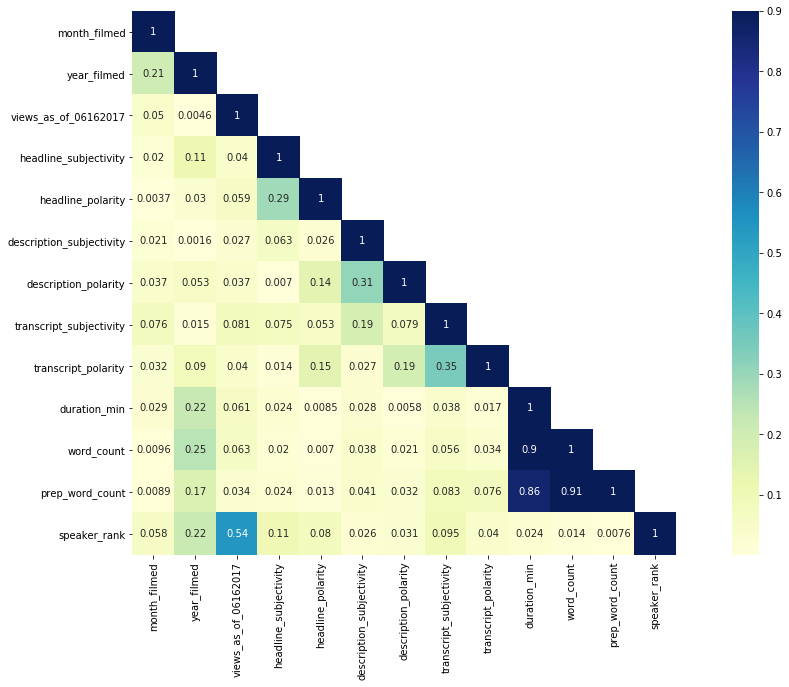

In [404]:
## Extracting Numeric features
numeric = clean_df.select_dtypes(['int64', 'float64']).copy()
numeric = numeric.drop(['Topic_ID'], axis=1)

## the correlation between numerical variables
num_corr = numeric.corr().abs()
mask = np.array(num_corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(num_corr, mask=mask,vmax=.9, square=True,annot=True, cmap="YlGnBu");

In [405]:
total_views = clean_df['views_as_of_06162017'].sum()
print('The total views from all the ted talks was ' + str(total_views))
average_durration_min = clean_df['duration_min'].mean()
print('The average duration in minutes from all the ted talks was ' + str(average_durration_min))

The total views from all the ted talks was 4027756287.0
The average duration in minutes from all the ted talks was 13.768416982988896


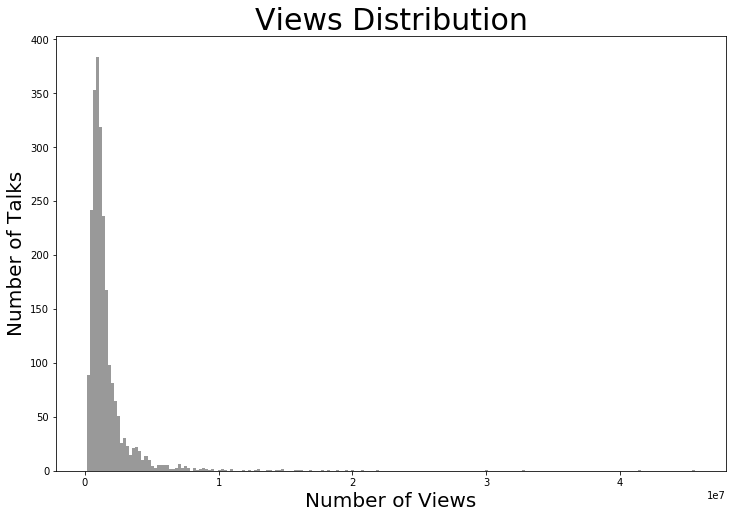

In [406]:
plt.figure(figsize=(12,8))
kwargs = dict(color='gray', histtype='stepfilled', alpha=0.8, bins=200)
plt.xlabel('Number of Views', fontsize=20)
plt.ylabel('Number of Talks',fontsize=20)
plt.title('Views Distribution',fontsize=30)
plt.hist(clean_df['views_as_of_06162017'], **kwargs);

In [407]:
print('The average number of views across our dataset is: ' + str(clean_df['views_as_of_06162017'].mean()))

The average number of views accorss our dataset is: 1698758.450864614


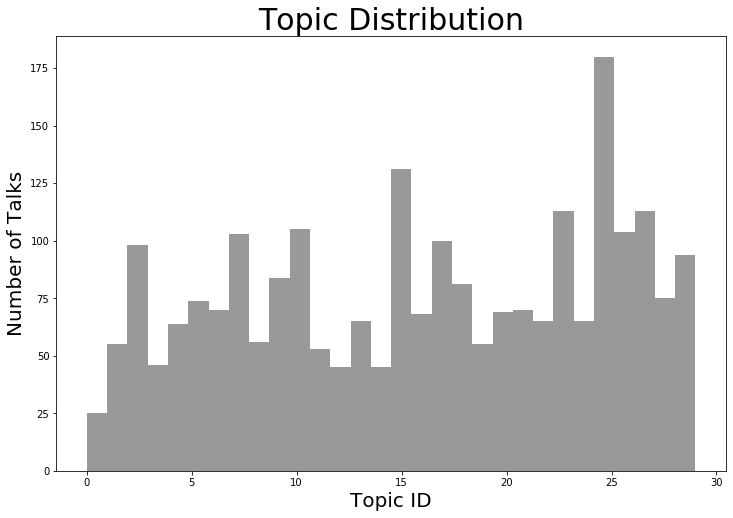

In [408]:
plt.figure(figsize=(12,8))
kwargs = dict(color='gray', histtype='stepfilled', alpha=0.8, bins=30)
plt.xlabel('Topic ID', fontsize=20)
plt.ylabel('Number of Talks',fontsize=20)
plt.title('Topic Distribution',fontsize=30)
plt.hist(clean_df['Topic_ID'], **kwargs);

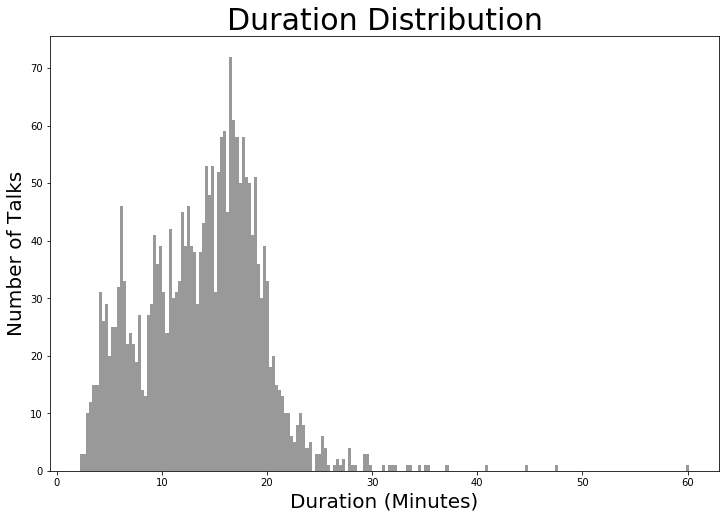

In [409]:
plt.figure(figsize=(12,8))
kwargs = dict(color='gray', histtype='stepfilled', alpha=0.8, bins=200)
plt.xlabel('Duration (Minutes)', fontsize=20)
plt.ylabel('Number of Talks',fontsize=20)
plt.title('Duration Distribution',fontsize=30)
plt.hist(clean_df['duration_min'], **kwargs);

In [410]:
def root_mean_squared_percentage_error(y_true, y_predicted):
    '''Calculates the error using the Root Mean Squared method'''
    rmspe = np.sqrt(np.mean(np.square((y_true-y_predicted)/y_true)))
    return rmspe

In [411]:
## Using OLS model to view error in prediction of the number of views.

one_hot_df = pd.concat([numeric, pd.get_dummies(clean_df['event'])], axis=1)
outcomes = one_hot_df['views_as_of_06162017'].copy()
one_hot_df.drop(['views_as_of_06162017'], axis=1, inplace=True)

numLoops = 100
percent_error = np.zeros(numLoops)


for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(one_hot_df, outcomes, test_size=0.2)
    model_n = sm.OLS(y_train, X_train).fit()
    predict_n = model_n.predict(X_test)
    percent_error = root_mean_squared_percentage_error(y_test,predict_n)

print('The mean error for our processing is:%.2f%%' %  (percent_error.mean()))

The mean error for our processing is:94.82%


In [412]:
## Using Ridge Regression model to view error in prediction of the number of views.

alpha_value = [1e-3, 1e-2, 3e-2, 6e-2, 1e-1, 3e-1, 6e-1, 1]
percentage_error_ridge = np.zeros(len(alpha_value))
percentage_error_ridge_cross_validation = np.zeros(len(alpha_value))

for index, alpha_val in enumerate(alpha_value):
    ridgereg = Ridge(alpha=alpha_val, normalize=True)
    ridgereg.fit(one_hot_df, outcomes)
    pred_ridge = pd.Series(ridgereg.predict(one_hot_df))
    pred_ridge.head()
    percentage_error_ridge[index] = root_mean_squared_percentage_error(outcomes,pred_ridge)
    
    ridge_error = np.zeros(numLoops)
    for idx in range(0,numLoops):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(one_hot_df, outcomes, test_size=0.2)
        ridgereg = Ridge(alpha=alpha_val, normalize=True)
        ridgereg.fit(X_train, y_train)
        pred_ridge = pd.Series(ridgereg.predict(X_test))
        y_test.reset_index(inplace=True, drop=True)
        ridge_error[idx] = root_mean_squared_percentage_error(y_test,pred_ridge)

    percentage_error_ridge_cross_validation[index] = ridge_error.mean()

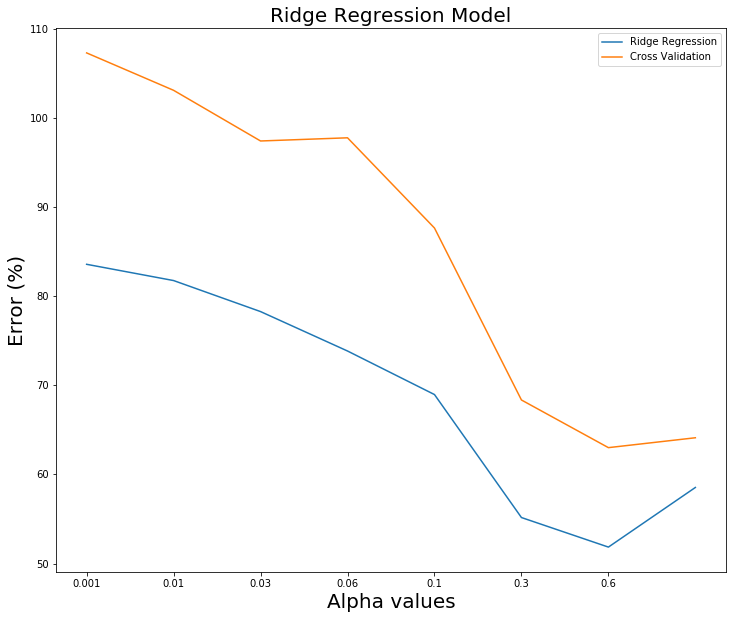

In [413]:
plt.figure(figsize=(12,10))
plt.plot(percentage_error_ridge*100, label = "Ridge Regression")
plt.plot(percentage_error_ridge_cross_validation*100, label= 'Cross Validation')
plt.xticks(ticks=np.arange(0,7), labels = alpha_value)
plt.xlabel('Alpha values', fontsize=20)
plt.ylabel('Error (%)', fontsize=20)
plt.title("Ridge Regression Model", fontsize=20)
plt.legend();

In [414]:
## save clean df to CSV for later use to reduce compile time in future
new_df = pd.DataFrame(index_reset)
new_df.to_csv('/Users/abdul/Desktop/Capstone/df_for_analysis.csv')

In [415]:
## Selecting target entry for the recommendation engine 
target = clean_df.iloc[[573]]

speaker                                        headline  \
573  Lalitesh Katragadda  Making maps to fight disaster, build economies   

                                      URL  \
573  http://www.ted.com/talks/view/id/736   

                                           description  \
573  As of 2005, only 15 percent of the world was m...   

                                        transcript_URL  month_filmed  \
573  http://www.ted.com/talks/view/id/736/transcrip...            11   

     year_filmed          event duration date_published  ...  \
573         2009  TEDIndia 2009  0:02:54        1/13/10  ...   

     transcript_subjectivity transcript_polarity duration_min  \
573                 0.555982            0.136285          2.9   

                                      prep_headline  \
573  [making, map, fight, disaster, build, economy]   

                                      prep_description  \
573  [2005, 15, percent, world, mapped, slows, deli...   

                                       prep_transcript  word_count  \
573  [2008, cyclone, nargis, devastated, myanmar, m...         358   

     prep_word_count  Topic_ID  speaker_rank  
573              149         9        2290.0  

[1 rows x 28 columns]

In [417]:
## Instantiating Count Vectorizer for analysis
processed_transcript = clean_df['prep_transcript'].astype(str)
cv = CountVectorizer(stop_words='english', min_df= 0.01, max_df = 0.9)
transcript_cv = cv.fit_transform(processed_transcript)

In [418]:
## Instantiating TFIDF Vectorizer for analysis
vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1), # considering only 1-grams
                        min_df = 0.01,     # cut words present in less than n% of documents
                        max_df = 0.9)      # cut words present in more than n% of documents 
t0 = time()

tfidf = vectorizer.fit_transform(clean_df['prep_transcript'].astype(str)) #fit the model

In [419]:
## Fit the Nearest Neighbor model on Count Vectorizer model
nn = NearestNeighbors(metric = 'euclidean')
nn.fit(transcript_cv)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [420]:
## This line of code finds the 10 nearest neighboring famous people to the original input
distances_cv, indices_cv = nn.kneighbors(transcript_cv[target.index], n_neighbors = 12)

In [421]:
## Fit the Nearest Neighbor model on TFIDF Vectorizer model
nn = NearestNeighbors(metric = 'euclidean')
nn.fit(tfidf)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [422]:
distances, indicies = nn.kneighbors(tfidf[target.index], n_neighbors = 12)

In [423]:
## Extracting top entries for Count Vectorizer model
similarEntries_cv = clean_df.iloc[indices_cv[0],:].copy()
similarEntries_cv.reset_index(inplace=True, drop=True)

In [424]:
## Extracting top entries for TFIDF Vectorizer model
similarEntries = clean_df.iloc[indicies[0],:].copy()
similarEntries.reset_index(inplace=True, drop=True)

speaker                                        headline  \
0     Lalitesh Katragadda  Making maps to fight disaster, build economies   
1           Maurice Conti       The incredible inventions of intuitive AI   
2            Parag Khanna                 Mapping the future of countries   
3  Blaise AgÃ¼era y Arcas                          Augmented-reality maps   
4         Tim Berners-Lee               The year open data went worldwide   

                                     URL  \
0   http://www.ted.com/talks/view/id/736   
1  http://www.ted.com/talks/view/id/2671   
2   http://www.ted.com/talks/view/id/645   
3   http://www.ted.com/talks/view/id/766   
4   http://www.ted.com/talks/view/id/788   

                                         description  \
0  As of 2005, only 15 percent of the world was m...   
1  What do you get when you give a design tool a ...   
2  Many people think the lines on the map no long...   
3  In a demo that drew gasps at TED2010, Blaise A...   
4  At TED2009, Tim Berners-Lee called for "raw da...   

                                      transcript_URL  month_filmed  \
0  http://www.ted.com/talks/view/id/736/transcrip...            11   
1  http://www.ted.com/talks/view/id/2674/transcri...             4   
2  http://www.ted.com/talks/view/id/645/transcrip...             7   
3  http://www.ted.com/talks/view/id/766/transcrip...             2   
4  http://www.ted.com/talks/view/id/788/transcrip...             2   

   year_filmed           event duration date_published  ...  \
0         2009   TEDIndia 2009  0:02:54        1/13/10  ...   
1         2016    TEDxPortland  0:15:23         2/6/17  ...   
2         2009  TEDGlobal 2009  0:18:53        9/28/09  ...   
3         2010         TED2010  0:07:45        2/13/10  ...   
4         2010         TED2010  0:05:33         3/8/10  ...   

   transcript_subjectivity transcript_polarity duration_min  \
0                 0.555982            0.136285     2.900000   
1                 0.409191            0.136037    15.383333   
2                 0.435085            0.142360    18.883333   
3                 0.458354            0.173192     7.750000   
4                 0.394229            0.090527     5.550000   

                                    prep_headline  \
0  [making, map, fight, disaster, build, economy]   
1          [incredible, invention, intuitive, ai]   
2                      [mapping, future, country]   
3                       [augmented, reality, map]   
4             [year, open, data, went, worldwide]   

                                    prep_description  \
0  [2005, 15, percent, world, mapped, slows, deli...   
1  [get, give, design, tool, digital, nervous, sy...   
2  [many, people, think, line, map, longer, matte...   
3  [demo, drew, gasp, ted2010, blaise, aguera, ar...   
4  [ted2009, tim, berners, lee, called, raw, data...   

                                     prep_transcript  word_count  \
0  [2008, cyclone, nargis, devastated, myanmar, m...         358   
1  [many, creatives, designer, engineer, entrepre...        2383   
2  [live, borderless, world, answer, look, map, c...        3261   
3  [year, half, ago, stephen, lawler, also, gave,...        1211   
4  [last, year, ted, asked, give, data, put, web,...        1002   

   prep_word_count  Topic_ID  speaker_rank  
0              149         9        2290.0  
1              577        29         395.0  
2              789        12        1544.0  
3              283        29         595.0  
4              271        10        1928.0  

[5 rows x 28 columns]

In [425]:
def build_wordclouds(dataframe):
    """Builds list of wordclouds titled by the name of the person"""
    figure = plt.figure(figsize=(50,30))
    for idx, row in dataframe.iterrows():
        name = row['speaker']
        text = ' '.join(row['prep_transcript'])
        views = row['views_as_of_06162017']
        topic = row['Topic_ID']
        # checks for empty string to make sure that only wordclouds with text values get made
        if text != "" :
            ax = figure.add_subplot(3,4, idx+1)
            wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
            ax.set_title(str(name), fontsize=50, color='black')
            ax.set_xlabel('Views: %s \n Topic ID: %s' % (views,topic), fontsize=50, color='black')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.plot()
            ax.imshow(wordcloud, interpolation="bilinear")
    plt.show()

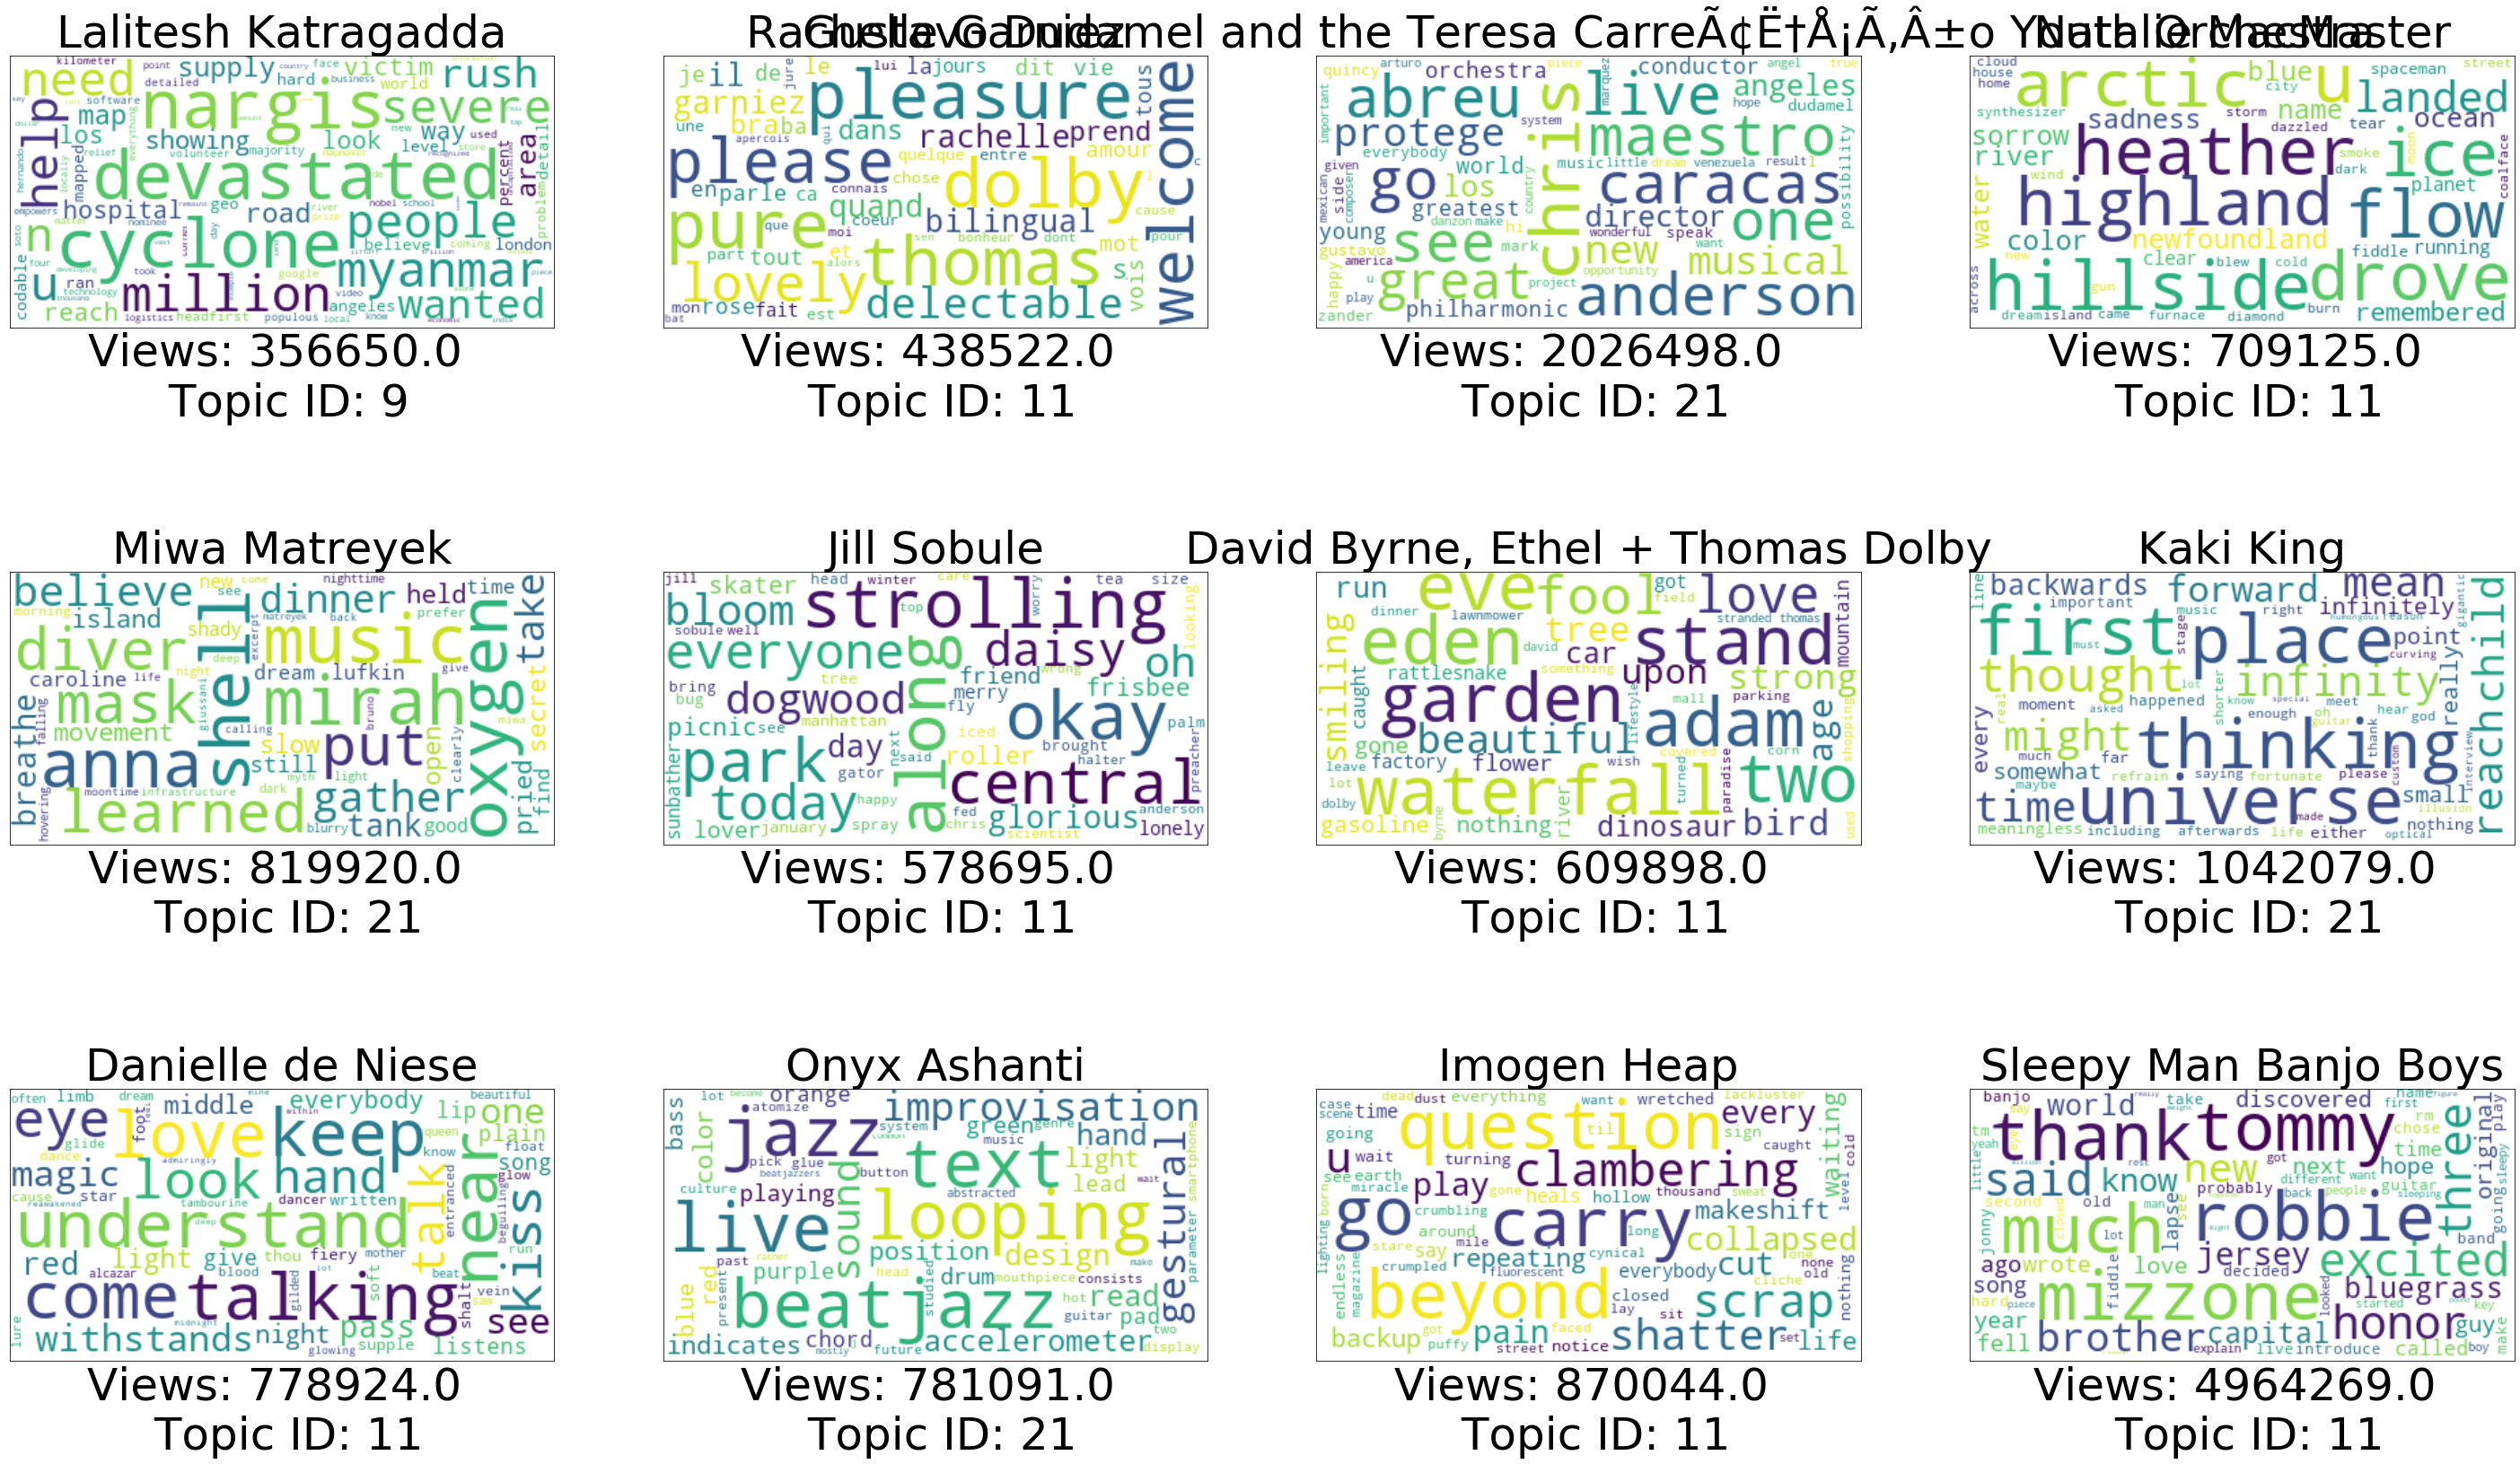

In [426]:
## Build Wordclouds for Count Vectorizer model
text_cv_df = similarEntries_cv.copy()
text_cv_df = text_cv_df[['speaker', 'prep_transcript','views_as_of_06162017', 'Topic_ID']]
build_wordclouds(text_cv_df)

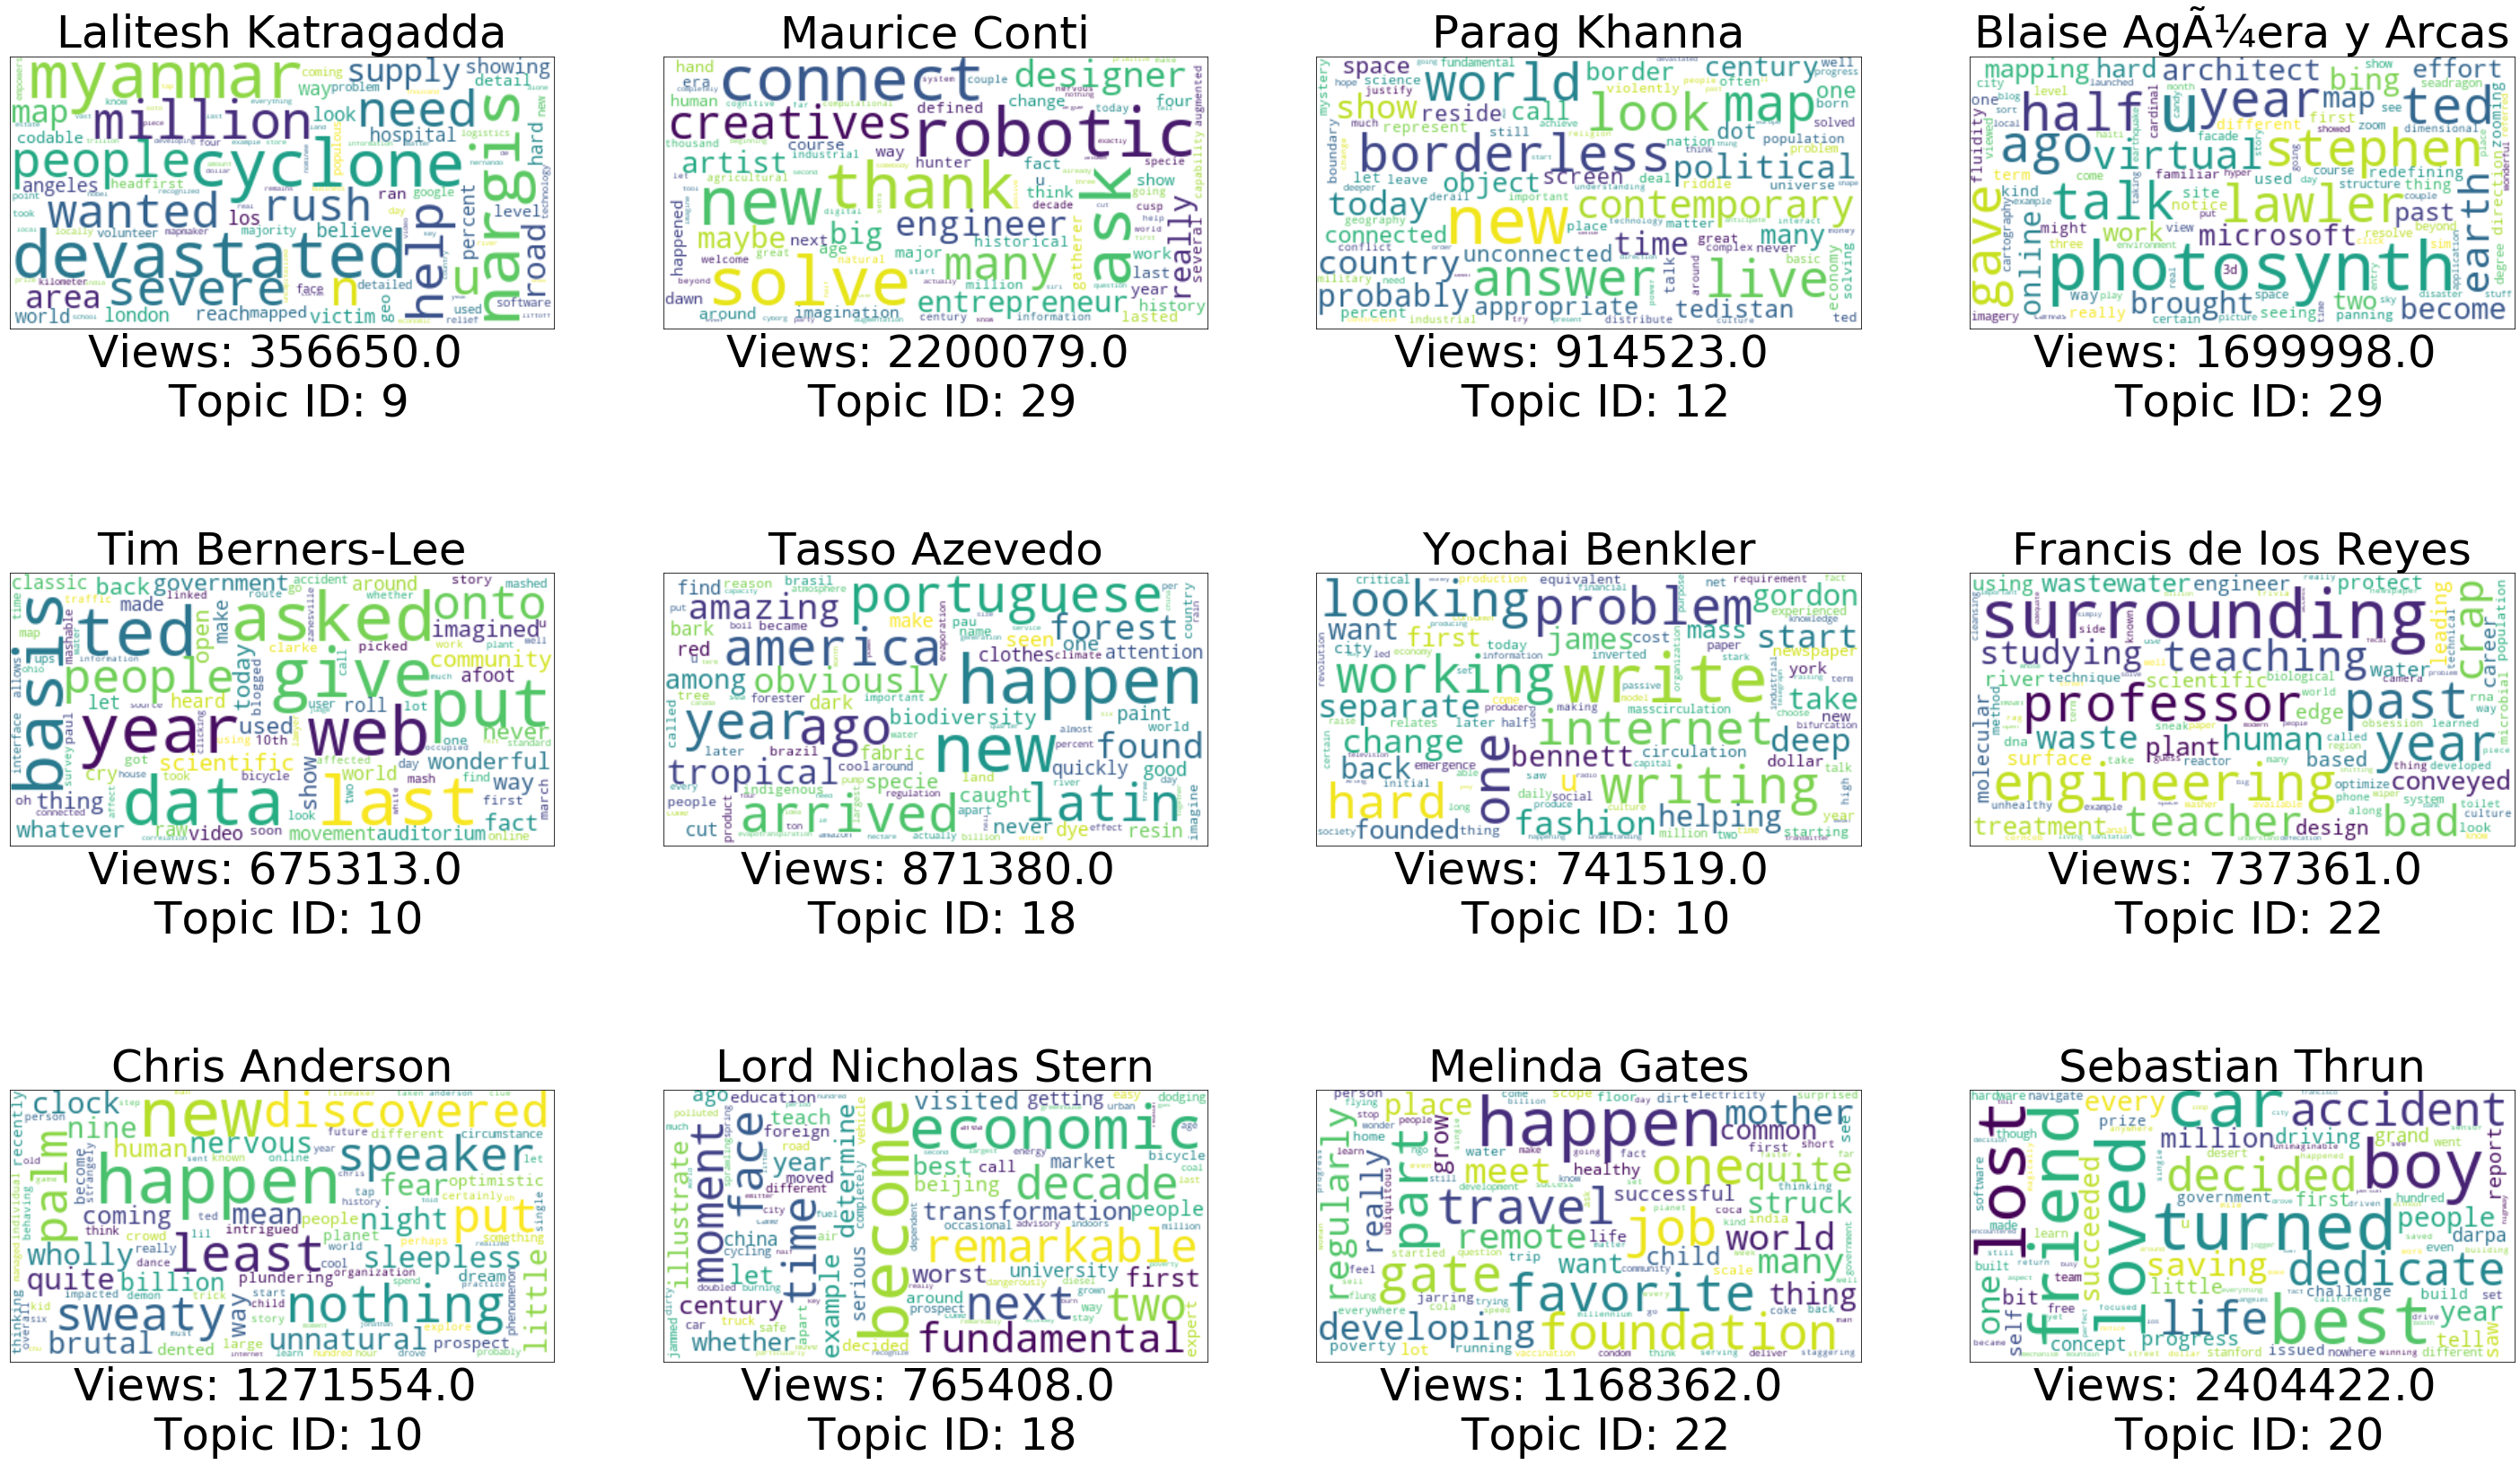

In [427]:
## Build Wordclouds for TFIDF Vectorizer model
text_df = similarEntries.copy()
text_df = text_df[['speaker', 'prep_transcript', 'views_as_of_06162017', 'Topic_ID']]
build_wordclouds(text_df)

In [428]:
def find_similar_talks(target_index, recommendation_count):
    """
    Accepts a target talk, using target_index, to use as a basis for recommendation
    and the number of recommendation results, using recommendation_count, that get returned
    """
    distances, indicies = nn.kneighbors(tfidf[target_index], n_neighbors = recommendation_count)
    similarEntries = clean_df.iloc[indicies[0],:].copy()
    similarEntries.reset_index(inplace=True, drop=True)
    for idx, row in similarEntries.iterrows():
        headline = similarEntries.headline[idx]
        query = headline.replace(" ", "+")
        search = urllib.request.urlopen("https://www.youtube.com/results?search_query=" + query)
        page = search.read().decode()
        video_ids = re.search(r'watch\?v=(\S{11})', page)
        id =video_ids.group(1)
        print('\033[1m' + headline + '\033[1m')
        display(YouTubeVideo(id))


Life in the deep oceans


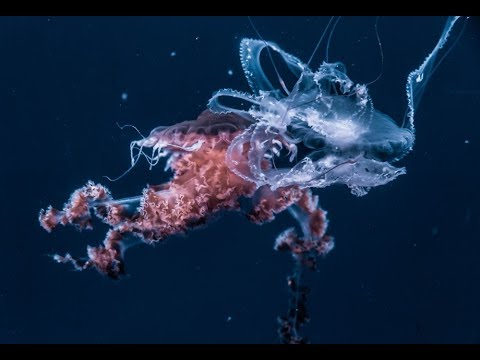

Hooked by an octopus


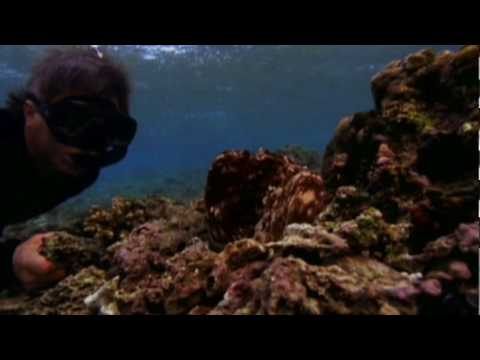

The astonishing hidden world of the deep ocean


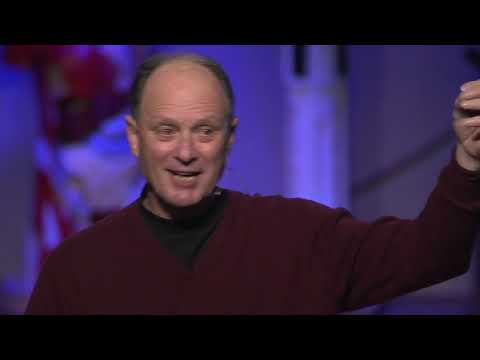

A census of the ocean


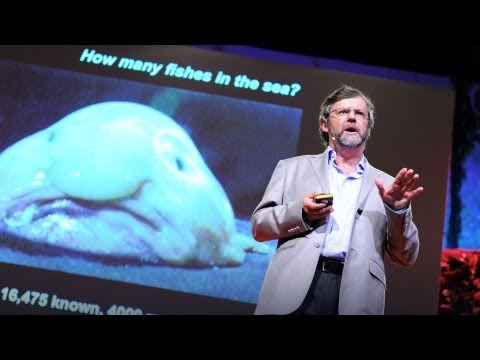

Wiring an interactive ocean


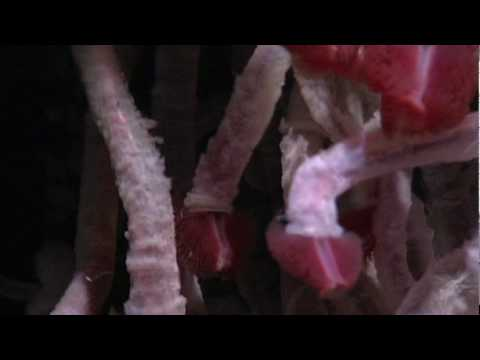

In [429]:
find_similar_talks(283, 5)